# Train ORCNN on amodal datasets

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog,MetadataCatalog
from detectron2.engine import DefaultTrainer
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.show()
    
# run on gpu 0 (NVIDIA Geforce GTX 1080Ti) and gpu 1 (NVIDIA Geforce GTX 1070Ti)
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

## Register the amodal datasets 

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("broccoli_amodal_train", {}, "datasets/20201231_size_experiment_realsense/train/annotations.json", "datasets/20201231_size_experiment_realsense/train")
register_coco_instances("broccoli_amodal_val", {}, "datasets/20201231_size_experiment_realsense/val/annotations.json", "datasets/20201231_size_experiment_realsense/val")
register_coco_instances("broccoli_amodal_test", {}, "datasets/20201231_size_experiment_realsense/test/annotations.json", "datasets/20201231_size_experiment_realsense/test")

In [3]:
broccoli_amodal_train_metadata = MetadataCatalog.get("broccoli_amodal_train")
print(broccoli_amodal_train_metadata)

broccoli_amodal_val_metadata = MetadataCatalog.get("broccoli_amodal_val")
print(broccoli_amodal_val_metadata)

broccoli_amodal_test_metadata = MetadataCatalog.get("broccoli_amodal_test")
print(broccoli_amodal_test_metadata)

Metadata(evaluator_type='coco', image_root='datasets/20201231_size_experiment_realsense/train', json_file='datasets/20201231_size_experiment_realsense/train/annotations.json', name='broccoli_amodal_train')
Metadata(evaluator_type='coco', image_root='datasets/20201231_size_experiment_realsense/val', json_file='datasets/20201231_size_experiment_realsense/val/annotations.json', name='broccoli_amodal_val')
Metadata(evaluator_type='coco', image_root='datasets/20201231_size_experiment_realsense/test', json_file='datasets/20201231_size_experiment_realsense/test/annotations.json', name='broccoli_amodal_test')


In [4]:
dataset_dicts_train = DatasetCatalog.get("broccoli_amodal_train")
dataset_dicts_val = DatasetCatalog.get("broccoli_amodal_val")
dataset_dicts_test = DatasetCatalog.get("broccoli_amodal_test")

[09/10 17:47:48 d2.data.datasets.coco]: Loaded 1119 images in COCO format from datasets/20201231_size_experiment_realsense/train/annotations.json
[09/10 17:47:48 d2.data.datasets.coco]: Loaded 352 images in COCO format from datasets/20201231_size_experiment_realsense/val/annotations.json
[09/10 17:47:48 d2.data.datasets.coco]: Loaded 362 images in COCO format from datasets/20201231_size_experiment_realsense/test/annotations.json


## Visualize the amodal dataset 

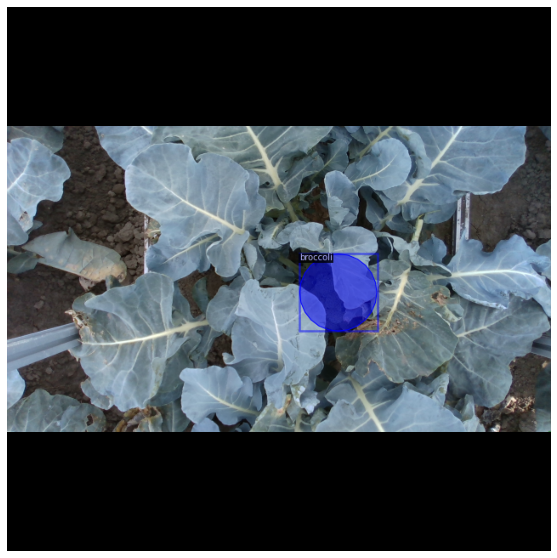

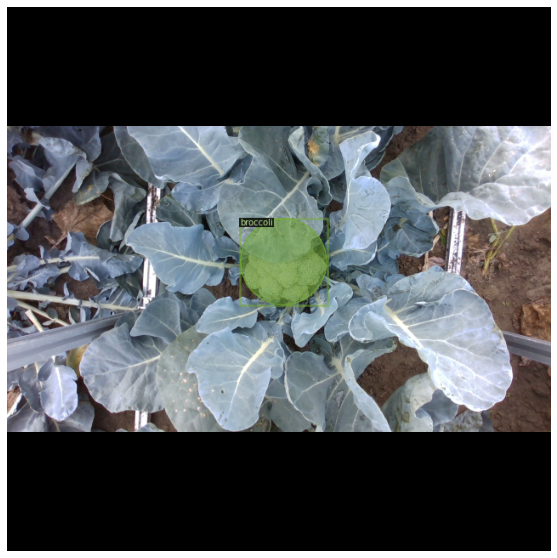

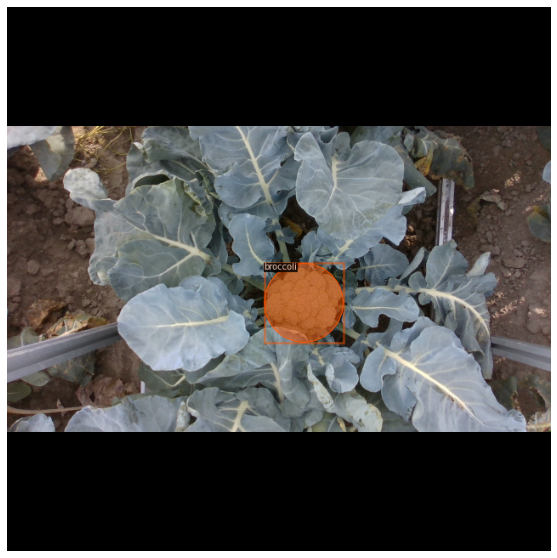

In [5]:
for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d, segm='segmentation')
    imshow(vis.get_image()[:, :, ::-1])

## Visualize the visible masks (modal dataset) 

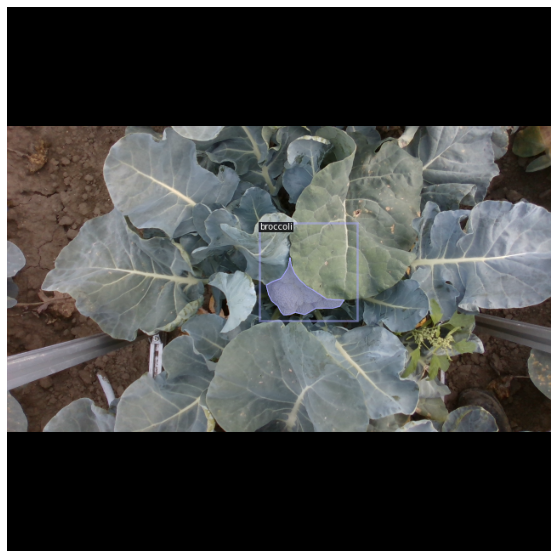

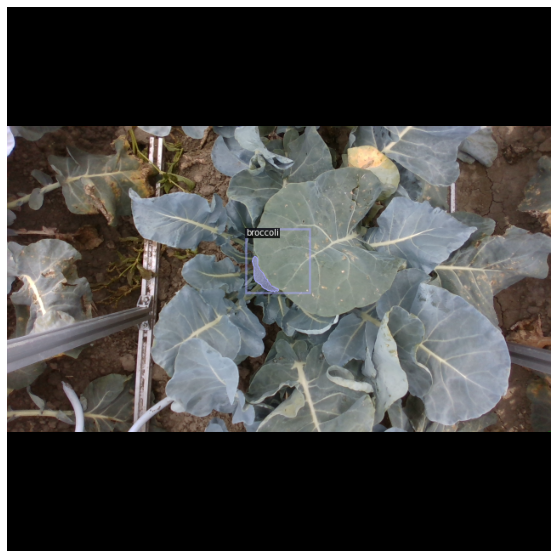

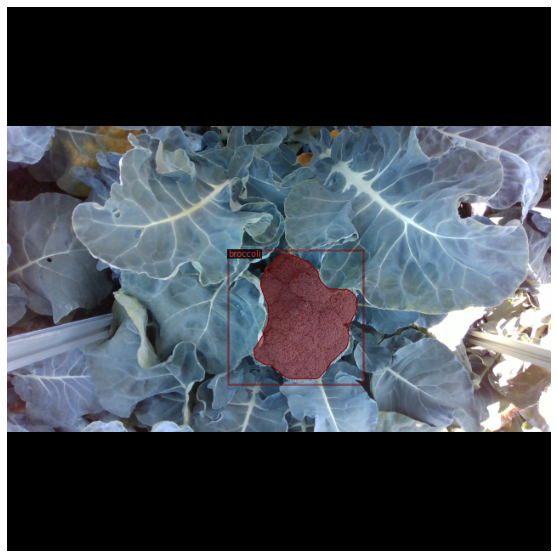

In [6]:
for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d, segm='visible_mask')
    imshow(vis.get_image()[:, :, ::-1])

## Initialize the training and inference parameters

In [7]:
# thanks to: https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
# thanks to: https://colab.research.google.com/drive/1-TNOcPm3Jr3fOJG8rnGT9gh60mHUsvaW#scrollTo=B4UESNQ4tyVm
# code extracted from: https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b

from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [8]:
from detectron2.evaluation import AmodalEvaluator

class AmodalTrainer(DefaultTrainer):
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return AmodalEvaluator(dataset_name, cfg, False, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            20,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [9]:
import os
import numpy as np
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_orcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("broccoli_amodal_train",)
cfg.DATASETS.TEST = ("broccoli_amodal_val",)
cfg.TEST.EVAL_PERIOD = 1000

cfg.NUM_GPUS = 2
cfg.DATALOADER.NUM_WORKERS = 2
 # Let training initialize from the pretrained amodal-visible network
cfg.MODEL.WEIGHTS = os.path.join("weights/broccoli_amodal_visible", "model_final.pth")

# solver file settings extracted from: https://github.com/facebookresearch/Detectron/blob/master/configs/04_2018_gn_baselines/scratch_e2e_mask_rcnn_R-101-FPN_3x_gn.yaml
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.LR_POLICY = 'steps_with_decay'
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = (5000, 9000, 9500)
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (broccoli)

# https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
cfg.OUTPUT_DIR = "weights/broccoli_realsense"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = AmodalTrainer(cfg) 

[09/10 17:48:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[09/10 17:48:08 d2.data.datasets.coco]: Loaded 1119 images in COCO format from datasets/20201231_size_experiment_realsense/train/annotations.json
[09/10 17:48:08 d2.data.build]: Removed 0 images with no usable annotations. 1119 images left.
[09/10 17:48:08 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  broccoli  | 1357         |
|            |              |
[09/10 17:48:08 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/10 17:48:08 d2.data.build]: Using training sampler TrainingSampler
[09/10 17:48:08 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/10 17:48:08 d2.data.datasets.coco]: Loaded 352 images in COCO format from datasets/20201

## Start the training 

In [20]:
trainer.resume_or_load(resume=False)
trainer.train()

[09/10 09:18:44 d2.engine.train_loop]: Starting training from iteration 5000
[09/10 09:18:58 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 09:19:04 detectron2]: Loss on Validation  done 52/352. 0.0000 s / img. ETA=0:00:36
[09/10 09:19:09 detectron2]: Loss on Validation  done 94/352. 0.0000 s / img. ETA=0:00:31
[09/10 09:19:14 detectron2]: Loss on Validation  done 136/352. 0.0000 s / img. ETA=0:00:26
[09/10 09:19:19 detectron2]: Loss on Validation  done 179/352. 0.0000 s / img. ETA=0:00:20
[09/10 09:19:24 detectron2]: Loss on Validation  done 221/352. 0.0000 s / img. ETA=0:00:15
[09/10 09:19:29 detectron2]: Loss on Validation  done 263/352. 0.0000 s / img. ETA=0:00:10
[09/10 09:19:34 detectron2]: Loss on Validation  done 305/352. 0.0000 s / img. ETA=0:00:05
[09/10 09:19:39 detectron2]: Loss on Validation  done 347/352. 0.0000 s / img. ETA=0:00:00
[09/10 09:19:40 d2.utils.events]: eta: 0:54:51  iter: 5019  total_loss: 0.457  loss_cls: 0.057  loss_box_re

[09/10 09:25:13 d2.utils.events]: eta: 0:52:26  iter: 5139  total_loss: 0.445  loss_cls: 0.046  loss_box_reg: 0.149  loss_amodal_mask: 0.182  loss_visible_mask: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.003  validation_loss: 0.450  time: 0.6406  data_time: 0.0023  lr: 0.002797  max_mem: 9024M
[09/10 09:25:27 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 09:25:32 detectron2]: Loss on Validation  done 52/352. 0.0000 s / img. ETA=0:00:36
[09/10 09:25:37 detectron2]: Loss on Validation  done 94/352. 0.0000 s / img. ETA=0:00:31
[09/10 09:25:42 detectron2]: Loss on Validation  done 136/352. 0.0000 s / img. ETA=0:00:26
[09/10 09:25:47 detectron2]: Loss on Validation  done 179/352. 0.0000 s / img. ETA=0:00:20
[09/10 09:25:52 detectron2]: Loss on Validation  done 220/352. 0.0000 s / img. ETA=0:00:15
[09/10 09:25:57 detectron2]: Loss on Validation  done 262/352. 0.0000 s / img. ETA=0:00:10
[09/10 09:26:02 detectron2]: Loss on Validation  done 304/352. 0.0000 

[09/10 09:31:38 detectron2]: Loss on Validation  done 302/352. 0.0000 s / img. ETA=0:00:06
[09/10 09:31:43 detectron2]: Loss on Validation  done 343/352. 0.0000 s / img. ETA=0:00:01
[09/10 09:31:45 d2.utils.events]: eta: 0:50:59  iter: 5279  total_loss: 0.500  loss_cls: 0.052  loss_box_reg: 0.162  loss_amodal_mask: 0.204  loss_visible_mask: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  validation_loss: 0.460  time: 0.6413  data_time: 0.0024  lr: 0.005594  max_mem: 9024M
[09/10 09:31:59 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:33
[09/10 09:32:04 detectron2]: Loss on Validation  done 51/352. 0.0000 s / img. ETA=0:00:36
[09/10 09:32:09 detectron2]: Loss on Validation  done 91/352. 0.0000 s / img. ETA=0:00:32
[09/10 09:32:14 detectron2]: Loss on Validation  done 133/352. 0.0000 s / img. ETA=0:00:27
[09/10 09:32:19 detectron2]: Loss on Validation  done 175/352. 0.0000 s / img. ETA=0:00:21
[09/10 09:32:24 detectron2]: Loss on Validation  done 215/352. 0.0000 

[09/10 09:38:03 detectron2]: Loss on Validation  done 260/352. 0.0000 s / img. ETA=0:00:11
[09/10 09:38:08 detectron2]: Loss on Validation  done 302/352. 0.0000 s / img. ETA=0:00:06
[09/10 09:38:13 detectron2]: Loss on Validation  done 343/352. 0.0000 s / img. ETA=0:00:01
[09/10 09:38:14 d2.utils.events]: eta: 0:49:22  iter: 5419  total_loss: 0.492  loss_cls: 0.058  loss_box_reg: 0.152  loss_amodal_mask: 0.190  loss_visible_mask: 0.074  loss_rpn_cls: 0.002  loss_rpn_loc: 0.004  validation_loss: 0.474  time: 0.6401  data_time: 0.0022  lr: 0.008392  max_mem: 9024M
[09/10 09:38:28 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 09:38:33 detectron2]: Loss on Validation  done 51/352. 0.0000 s / img. ETA=0:00:36
[09/10 09:38:38 detectron2]: Loss on Validation  done 93/352. 0.0000 s / img. ETA=0:00:31
[09/10 09:38:44 detectron2]: Loss on Validation  done 135/352. 0.0000 s / img. ETA=0:00:26
[09/10 09:38:49 detectron2]: Loss on Validation  done 177/352. 0.0000 

[09/10 09:44:24 detectron2]: Loss on Validation  done 179/352. 0.0000 s / img. ETA=0:00:20
[09/10 09:44:29 detectron2]: Loss on Validation  done 221/352. 0.0000 s / img. ETA=0:00:15
[09/10 09:44:34 detectron2]: Loss on Validation  done 264/352. 0.0000 s / img. ETA=0:00:10
[09/10 09:44:39 detectron2]: Loss on Validation  done 306/352. 0.0000 s / img. ETA=0:00:05
[09/10 09:44:44 detectron2]: Loss on Validation  done 349/352. 0.0000 s / img. ETA=0:00:00
[09/10 09:44:45 d2.utils.events]: eta: 0:47:58  iter: 5559  total_loss: 0.663  loss_cls: 0.066  loss_box_reg: 0.172  loss_amodal_mask: 0.232  loss_visible_mask: 0.105  loss_rpn_cls: 0.002  loss_rpn_loc: 0.003  validation_loss: 0.512  time: 0.6410  data_time: 0.0025  lr: 0.011189  max_mem: 9024M
[09/10 09:44:59 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:30
[09/10 09:45:04 detectron2]: Loss on Validation  done 52/352. 0.0000 s / img. ETA=0:00:35
[09/10 09:45:09 detectron2]: Loss on Validation  done 94/352. 0.0000 

[09/10 09:50:40 detectron2]: Loss on Validation  done 94/352. 0.0000 s / img. ETA=0:00:31
[09/10 09:50:45 detectron2]: Loss on Validation  done 136/352. 0.0000 s / img. ETA=0:00:26
[09/10 09:50:51 detectron2]: Loss on Validation  done 179/352. 0.0000 s / img. ETA=0:00:20
[09/10 09:50:56 detectron2]: Loss on Validation  done 221/352. 0.0000 s / img. ETA=0:00:15
[09/10 09:51:01 detectron2]: Loss on Validation  done 264/352. 0.0000 s / img. ETA=0:00:10
[09/10 09:51:06 detectron2]: Loss on Validation  done 306/352. 0.0000 s / img. ETA=0:00:05
[09/10 09:51:11 detectron2]: Loss on Validation  done 348/352. 0.0000 s / img. ETA=0:00:00
[09/10 09:51:12 d2.utils.events]: eta: 0:46:22  iter: 5699  total_loss: 0.491  loss_cls: 0.050  loss_box_reg: 0.170  loss_amodal_mask: 0.187  loss_visible_mask: 0.064  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  validation_loss: 0.537  time: 0.6390  data_time: 0.0024  lr: 0.013986  max_mem: 9024M
[09/10 09:51:26 detectron2]: Loss on Validation  done 11/352. 0.0000

[09/10 09:57:03 detectron2]: Loss on Validation  done 52/352. 0.0000 s / img. ETA=0:00:35
[09/10 09:57:08 detectron2]: Loss on Validation  done 95/352. 0.0000 s / img. ETA=0:00:30
[09/10 09:57:13 detectron2]: Loss on Validation  done 137/352. 0.0000 s / img. ETA=0:00:25
[09/10 09:57:18 detectron2]: Loss on Validation  done 180/352. 0.0000 s / img. ETA=0:00:20
[09/10 09:57:23 detectron2]: Loss on Validation  done 222/352. 0.0000 s / img. ETA=0:00:15
[09/10 09:57:28 detectron2]: Loss on Validation  done 266/352. 0.0000 s / img. ETA=0:00:10
[09/10 09:57:33 detectron2]: Loss on Validation  done 308/352. 0.0000 s / img. ETA=0:00:05
[09/10 09:57:38 detectron2]: Loss on Validation  done 351/352. 0.0000 s / img. ETA=0:00:00
[09/10 09:57:38 d2.utils.events]: eta: 0:44:51  iter: 5839  total_loss: 0.644  loss_cls: 0.065  loss_box_reg: 0.200  loss_amodal_mask: 0.217  loss_visible_mask: 0.096  loss_rpn_cls: 0.002  loss_rpn_loc: 0.006  validation_loss: 0.557  time: 0.6380  data_time: 0.0025  lr: 0.0

[09/10 10:03:28 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:30
[09/10 10:03:33 detectron2]: Loss on Validation  done 52/352. 0.0000 s / img. ETA=0:00:35
[09/10 10:03:38 detectron2]: Loss on Validation  done 94/352. 0.0000 s / img. ETA=0:00:30
[09/10 10:03:43 detectron2]: Loss on Validation  done 136/352. 0.0000 s / img. ETA=0:00:25
[09/10 10:03:48 detectron2]: Loss on Validation  done 179/352. 0.0000 s / img. ETA=0:00:20
[09/10 10:03:53 detectron2]: Loss on Validation  done 221/352. 0.0000 s / img. ETA=0:00:15
[09/10 10:03:58 detectron2]: Loss on Validation  done 264/352. 0.0000 s / img. ETA=0:00:10
[09/10 10:04:03 detectron2]: Loss on Validation  done 306/352. 0.0000 s / img. ETA=0:00:05
[09/10 10:04:08 detectron2]: Loss on Validation  done 349/352. 0.0000 s / img. ETA=0:00:00
[09/10 10:04:09 d2.utils.events]: eta: 0:43:21  iter: 5979  total_loss: 0.516  loss_cls: 0.054  loss_box_reg: 0.146  loss_amodal_mask: 0.215  loss_visible_mask: 0.079  loss_rpn_cls: 0.

[09/10 10:05:11 d2.evaluation.testing]: copypaste: 58.7867,94.6943,63.8967,nan,nan,58.8533
[09/10 10:05:11 d2.evaluation.testing]: copypaste: Task: visible
[09/10 10:05:11 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/10 10:05:11 d2.evaluation.testing]: copypaste: 73.5879,94.6508,84.6685,nan,nan,73.6312
[09/10 10:05:13 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 10:05:18 detectron2]: Loss on Validation  done 51/352. 0.0000 s / img. ETA=0:00:36
[09/10 10:05:23 detectron2]: Loss on Validation  done 92/352. 0.0000 s / img. ETA=0:00:31
[09/10 10:05:28 detectron2]: Loss on Validation  done 133/352. 0.0000 s / img. ETA=0:00:26
[09/10 10:05:33 detectron2]: Loss on Validation  done 174/352. 0.0000 s / img. ETA=0:00:21
[09/10 10:05:38 detectron2]: Loss on Validation  done 215/352. 0.0000 s / img. ETA=0:00:16
[09/10 10:05:43 detectron2]: Loss on Validation  done 257/352. 0.0000 s / img. ETA=0:00:11
[09/10 10:05:48 detectron2]: Loss on Valida

[09/10 10:11:28 detectron2]: Loss on Validation  done 302/352. 0.0000 s / img. ETA=0:00:06
[09/10 10:11:33 detectron2]: Loss on Validation  done 343/352. 0.0000 s / img. ETA=0:00:01
[09/10 10:11:34 d2.utils.events]: eta: 0:41:59  iter: 6119  total_loss: 0.525  loss_cls: 0.047  loss_box_reg: 0.174  loss_amodal_mask: 0.227  loss_visible_mask: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.005  validation_loss: 0.609  time: 0.6410  data_time: 0.0026  lr: 0.020000  max_mem: 9024M
[09/10 10:11:49 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:32
[09/10 10:11:54 detectron2]: Loss on Validation  done 49/352. 0.0000 s / img. ETA=0:00:38
[09/10 10:11:59 detectron2]: Loss on Validation  done 89/352. 0.0000 s / img. ETA=0:00:33
[09/10 10:12:04 detectron2]: Loss on Validation  done 128/352. 0.0000 s / img. ETA=0:00:28
[09/10 10:12:09 detectron2]: Loss on Validation  done 168/352. 0.0000 s / img. ETA=0:00:23
[09/10 10:12:14 detectron2]: Loss on Validation  done 209/352. 0.0000 

[09/10 10:18:04 detectron2]: Loss on Validation  done 166/352. 0.0000 s / img. ETA=0:00:24
[09/10 10:18:09 detectron2]: Loss on Validation  done 205/352. 0.0000 s / img. ETA=0:00:19
[09/10 10:18:14 detectron2]: Loss on Validation  done 243/352. 0.0000 s / img. ETA=0:00:14
[09/10 10:18:19 detectron2]: Loss on Validation  done 283/352. 0.0000 s / img. ETA=0:00:08
[09/10 10:18:24 detectron2]: Loss on Validation  done 322/352. 0.0000 s / img. ETA=0:00:03
[09/10 10:18:28 d2.utils.events]: eta: 0:40:44  iter: 6259  total_loss: 0.630  loss_cls: 0.068  loss_box_reg: 0.237  loss_amodal_mask: 0.214  loss_visible_mask: 0.060  loss_rpn_cls: 0.002  loss_rpn_loc: 0.006  validation_loss: 0.585  time: 0.6452  data_time: 0.0028  lr: 0.020000  max_mem: 9024M
[09/10 10:18:44 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:33
[09/10 10:18:49 detectron2]: Loss on Validation  done 48/352. 0.0000 s / img. ETA=0:00:40
[09/10 10:18:54 detectron2]: Loss on Validation  done 86/352. 0.0000 

[09/10 10:24:43 detectron2]: Loss on Validation  done 92/352. 0.0000 s / img. ETA=0:00:31
[09/10 10:24:48 detectron2]: Loss on Validation  done 133/352. 0.0000 s / img. ETA=0:00:26
[09/10 10:24:53 detectron2]: Loss on Validation  done 175/352. 0.0000 s / img. ETA=0:00:21
[09/10 10:24:58 detectron2]: Loss on Validation  done 216/352. 0.0000 s / img. ETA=0:00:16
[09/10 10:25:03 detectron2]: Loss on Validation  done 258/352. 0.0000 s / img. ETA=0:00:11
[09/10 10:25:08 detectron2]: Loss on Validation  done 299/352. 0.0000 s / img. ETA=0:00:06
[09/10 10:25:13 detectron2]: Loss on Validation  done 338/352. 0.0000 s / img. ETA=0:00:01
[09/10 10:25:15 d2.utils.events]: eta: 0:39:20  iter: 6399  total_loss: 0.507  loss_cls: 0.055  loss_box_reg: 0.176  loss_amodal_mask: 0.185  loss_visible_mask: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  validation_loss: 0.576  time: 0.6470  data_time: 0.0025  lr: 0.020000  max_mem: 9024M
[09/10 10:25:30 detectron2]: Loss on Validation  done 11/352. 0.0000

[09/10 10:31:09 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 10:31:14 detectron2]: Loss on Validation  done 51/352. 0.0000 s / img. ETA=0:00:37
[09/10 10:31:19 detectron2]: Loss on Validation  done 92/352. 0.0000 s / img. ETA=0:00:32
[09/10 10:31:24 detectron2]: Loss on Validation  done 133/352. 0.0000 s / img. ETA=0:00:27
[09/10 10:31:29 detectron2]: Loss on Validation  done 174/352. 0.0000 s / img. ETA=0:00:22
[09/10 10:31:34 detectron2]: Loss on Validation  done 214/352. 0.0000 s / img. ETA=0:00:17
[09/10 10:31:40 detectron2]: Loss on Validation  done 253/352. 0.0000 s / img. ETA=0:00:12
[09/10 10:31:45 detectron2]: Loss on Validation  done 292/352. 0.0000 s / img. ETA=0:00:07
[09/10 10:31:50 detectron2]: Loss on Validation  done 332/352. 0.0000 s / img. ETA=0:00:02
[09/10 10:31:52 d2.utils.events]: eta: 0:37:46  iter: 6539  total_loss: 0.440  loss_cls: 0.043  loss_box_reg: 0.159  loss_amodal_mask: 0.142  loss_visible_mask: 0.063  loss_rpn_cls: 0.

[09/10 10:38:05 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:32
[09/10 10:38:10 detectron2]: Loss on Validation  done 48/352. 0.0000 s / img. ETA=0:00:39
[09/10 10:38:15 detectron2]: Loss on Validation  done 87/352. 0.0000 s / img. ETA=0:00:34
[09/10 10:38:20 detectron2]: Loss on Validation  done 126/352. 0.0000 s / img. ETA=0:00:29
[09/10 10:38:25 detectron2]: Loss on Validation  done 165/352. 0.0000 s / img. ETA=0:00:24
[09/10 10:38:30 detectron2]: Loss on Validation  done 205/352. 0.0000 s / img. ETA=0:00:19
[09/10 10:38:35 detectron2]: Loss on Validation  done 243/352. 0.0000 s / img. ETA=0:00:14
[09/10 10:38:41 detectron2]: Loss on Validation  done 283/352. 0.0000 s / img. ETA=0:00:08
[09/10 10:38:46 detectron2]: Loss on Validation  done 322/352. 0.0000 s / img. ETA=0:00:03
[09/10 10:38:50 d2.utils.events]: eta: 0:36:33  iter: 6679  total_loss: 0.467  loss_cls: 0.060  loss_box_reg: 0.161  loss_amodal_mask: 0.184  loss_visible_mask: 0.063  loss_rpn_cls: 0.

[09/10 10:45:07 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:32
[09/10 10:45:12 detectron2]: Loss on Validation  done 50/352. 0.0000 s / img. ETA=0:00:37
[09/10 10:45:17 detectron2]: Loss on Validation  done 90/352. 0.0000 s / img. ETA=0:00:33
[09/10 10:45:22 detectron2]: Loss on Validation  done 130/352. 0.0000 s / img. ETA=0:00:28
[09/10 10:45:27 detectron2]: Loss on Validation  done 170/352. 0.0000 s / img. ETA=0:00:23
[09/10 10:45:32 detectron2]: Loss on Validation  done 209/352. 0.0000 s / img. ETA=0:00:18
[09/10 10:45:37 detectron2]: Loss on Validation  done 246/352. 0.0000 s / img. ETA=0:00:13
[09/10 10:45:42 detectron2]: Loss on Validation  done 286/352. 0.0000 s / img. ETA=0:00:08
[09/10 10:45:47 detectron2]: Loss on Validation  done 326/352. 0.0000 s / img. ETA=0:00:03
[09/10 10:45:51 d2.utils.events]: eta: 0:35:24  iter: 6819  total_loss: 0.479  loss_cls: 0.053  loss_box_reg: 0.195  loss_amodal_mask: 0.175  loss_visible_mask: 0.052  loss_rpn_cls: 0.

[09/10 10:51:50 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:30
[09/10 10:51:56 detectron2]: Loss on Validation  done 50/352. 0.0000 s / img. ETA=0:00:37
[09/10 10:52:01 detectron2]: Loss on Validation  done 89/352. 0.0000 s / img. ETA=0:00:33
[09/10 10:52:06 detectron2]: Loss on Validation  done 129/352. 0.0000 s / img. ETA=0:00:28
[09/10 10:52:11 detectron2]: Loss on Validation  done 169/352. 0.0000 s / img. ETA=0:00:23
[09/10 10:52:16 detectron2]: Loss on Validation  done 209/352. 0.0000 s / img. ETA=0:00:18
[09/10 10:52:21 detectron2]: Loss on Validation  done 248/352. 0.0000 s / img. ETA=0:00:13
[09/10 10:52:26 detectron2]: Loss on Validation  done 289/352. 0.0000 s / img. ETA=0:00:08
[09/10 10:52:31 detectron2]: Loss on Validation  done 329/352. 0.0000 s / img. ETA=0:00:02
[09/10 10:52:34 d2.utils.events]: eta: 0:33:53  iter: 6959  total_loss: 0.495  loss_cls: 0.058  loss_box_reg: 0.203  loss_amodal_mask: 0.162  loss_visible_mask: 0.050  loss_rpn_cls: 0.

[09/10 10:54:32 d2.evaluation.AmodalCocoEvaluation]: Note that some metrics cannot be computed.
[09/10 10:54:32 d2.engine.defaults]: Evaluation results for broccoli_amodal_val in csv format:
[09/10 10:54:32 d2.evaluation.testing]: copypaste: Task: bbox
[09/10 10:54:32 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/10 10:54:32 d2.evaluation.testing]: copypaste: 57.4738,89.3263,61.3404,nan,nan,57.6914
[09/10 10:54:32 d2.evaluation.testing]: copypaste: Task: segm
[09/10 10:54:32 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/10 10:54:32 d2.evaluation.testing]: copypaste: 57.8797,88.5226,62.1849,nan,nan,58.1437
[09/10 10:54:32 d2.evaluation.testing]: copypaste: Task: visible
[09/10 10:54:32 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/10 10:54:32 d2.evaluation.testing]: copypaste: 79.1210,96.0574,87.3219,nan,nan,79.2377
[09/10 10:54:34 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:30
[09/10 10:54:39 detectron2]: 

[09/10 11:00:26 detectron2]: Loss on Validation  done 49/352. 0.0000 s / img. ETA=0:00:38
[09/10 11:00:31 detectron2]: Loss on Validation  done 90/352. 0.0000 s / img. ETA=0:00:32
[09/10 11:00:36 detectron2]: Loss on Validation  done 130/352. 0.0000 s / img. ETA=0:00:28
[09/10 11:00:41 detectron2]: Loss on Validation  done 170/352. 0.0000 s / img. ETA=0:00:23
[09/10 11:00:46 detectron2]: Loss on Validation  done 211/352. 0.0000 s / img. ETA=0:00:17
[09/10 11:00:51 detectron2]: Loss on Validation  done 252/352. 0.0000 s / img. ETA=0:00:12
[09/10 11:00:56 detectron2]: Loss on Validation  done 293/352. 0.0000 s / img. ETA=0:00:07
[09/10 11:01:01 detectron2]: Loss on Validation  done 333/352. 0.0000 s / img. ETA=0:00:02
[09/10 11:01:04 d2.utils.events]: eta: 0:32:08  iter: 7119  total_loss: 0.383  loss_cls: 0.048  loss_box_reg: 0.139  loss_amodal_mask: 0.136  loss_visible_mask: 0.059  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.470  time: 0.6528  data_time: 0.0025  lr: 0.0

[09/10 11:07:03 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 11:07:08 detectron2]: Loss on Validation  done 50/352. 0.0000 s / img. ETA=0:00:37
[09/10 11:07:13 detectron2]: Loss on Validation  done 90/352. 0.0000 s / img. ETA=0:00:32
[09/10 11:07:19 detectron2]: Loss on Validation  done 130/352. 0.0000 s / img. ETA=0:00:27
[09/10 11:07:24 detectron2]: Loss on Validation  done 171/352. 0.0000 s / img. ETA=0:00:22
[09/10 11:07:29 detectron2]: Loss on Validation  done 212/352. 0.0000 s / img. ETA=0:00:17
[09/10 11:07:34 detectron2]: Loss on Validation  done 252/352. 0.0000 s / img. ETA=0:00:12
[09/10 11:07:39 detectron2]: Loss on Validation  done 293/352. 0.0000 s / img. ETA=0:00:07
[09/10 11:07:44 detectron2]: Loss on Validation  done 333/352. 0.0000 s / img. ETA=0:00:02
[09/10 11:07:46 d2.utils.events]: eta: 0:30:20  iter: 7259  total_loss: 0.463  loss_cls: 0.051  loss_box_reg: 0.180  loss_amodal_mask: 0.174  loss_visible_mask: 0.073  loss_rpn_cls: 0.

[09/10 11:13:47 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:32
[09/10 11:13:52 detectron2]: Loss on Validation  done 50/352. 0.0000 s / img. ETA=0:00:37
[09/10 11:13:57 detectron2]: Loss on Validation  done 90/352. 0.0000 s / img. ETA=0:00:32
[09/10 11:14:02 detectron2]: Loss on Validation  done 129/352. 0.0000 s / img. ETA=0:00:28
[09/10 11:14:07 detectron2]: Loss on Validation  done 168/352. 0.0000 s / img. ETA=0:00:23
[09/10 11:14:12 detectron2]: Loss on Validation  done 208/352. 0.0000 s / img. ETA=0:00:18
[09/10 11:14:17 detectron2]: Loss on Validation  done 248/352. 0.0000 s / img. ETA=0:00:13
[09/10 11:14:22 detectron2]: Loss on Validation  done 289/352. 0.0000 s / img. ETA=0:00:07
[09/10 11:14:27 detectron2]: Loss on Validation  done 330/352. 0.0000 s / img. ETA=0:00:02
[09/10 11:14:30 d2.utils.events]: eta: 0:28:46  iter: 7399  total_loss: 0.433  loss_cls: 0.044  loss_box_reg: 0.149  loss_amodal_mask: 0.157  loss_visible_mask: 0.057  loss_rpn_cls: 0.

[09/10 11:20:31 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 11:20:36 detectron2]: Loss on Validation  done 50/352. 0.0000 s / img. ETA=0:00:37
[09/10 11:20:42 detectron2]: Loss on Validation  done 90/352. 0.0000 s / img. ETA=0:00:32
[09/10 11:20:47 detectron2]: Loss on Validation  done 130/352. 0.0000 s / img. ETA=0:00:27
[09/10 11:20:52 detectron2]: Loss on Validation  done 170/352. 0.0000 s / img. ETA=0:00:22
[09/10 11:20:57 detectron2]: Loss on Validation  done 210/352. 0.0000 s / img. ETA=0:00:17
[09/10 11:21:02 detectron2]: Loss on Validation  done 250/352. 0.0000 s / img. ETA=0:00:12
[09/10 11:21:07 detectron2]: Loss on Validation  done 291/352. 0.0000 s / img. ETA=0:00:07
[09/10 11:21:12 detectron2]: Loss on Validation  done 330/352. 0.0000 s / img. ETA=0:00:02
[09/10 11:21:15 d2.utils.events]: eta: 0:27:19  iter: 7539  total_loss: 0.399  loss_cls: 0.041  loss_box_reg: 0.140  loss_amodal_mask: 0.138  loss_visible_mask: 0.061  loss_rpn_cls: 0.

[09/10 11:27:16 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 11:27:21 detectron2]: Loss on Validation  done 49/352. 0.0000 s / img. ETA=0:00:38
[09/10 11:27:26 detectron2]: Loss on Validation  done 89/352. 0.0000 s / img. ETA=0:00:33
[09/10 11:27:31 detectron2]: Loss on Validation  done 128/352. 0.0000 s / img. ETA=0:00:28
[09/10 11:27:36 detectron2]: Loss on Validation  done 168/352. 0.0000 s / img. ETA=0:00:23
[09/10 11:27:41 detectron2]: Loss on Validation  done 208/352. 0.0000 s / img. ETA=0:00:18
[09/10 11:27:46 detectron2]: Loss on Validation  done 247/352. 0.0000 s / img. ETA=0:00:13
[09/10 11:27:51 detectron2]: Loss on Validation  done 288/352. 0.0000 s / img. ETA=0:00:08
[09/10 11:27:56 detectron2]: Loss on Validation  done 327/352. 0.0000 s / img. ETA=0:00:03
[09/10 11:28:00 d2.utils.events]: eta: 0:25:40  iter: 7679  total_loss: 0.424  loss_cls: 0.048  loss_box_reg: 0.148  loss_amodal_mask: 0.155  loss_visible_mask: 0.052  loss_rpn_cls: 0.

[09/10 11:34:07 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 11:34:12 detectron2]: Loss on Validation  done 51/352. 0.0000 s / img. ETA=0:00:37
[09/10 11:34:17 detectron2]: Loss on Validation  done 91/352. 0.0000 s / img. ETA=0:00:32
[09/10 11:34:22 detectron2]: Loss on Validation  done 132/352. 0.0000 s / img. ETA=0:00:27
[09/10 11:34:27 detectron2]: Loss on Validation  done 173/352. 0.0000 s / img. ETA=0:00:22
[09/10 11:34:32 detectron2]: Loss on Validation  done 213/352. 0.0000 s / img. ETA=0:00:17
[09/10 11:34:37 detectron2]: Loss on Validation  done 254/352. 0.0000 s / img. ETA=0:00:12
[09/10 11:34:42 detectron2]: Loss on Validation  done 295/352. 0.0000 s / img. ETA=0:00:07
[09/10 11:34:47 detectron2]: Loss on Validation  done 335/352. 0.0000 s / img. ETA=0:00:02
[09/10 11:34:50 d2.utils.events]: eta: 0:24:01  iter: 7819  total_loss: 0.392  loss_cls: 0.050  loss_box_reg: 0.126  loss_amodal_mask: 0.133  loss_visible_mask: 0.058  loss_rpn_cls: 0.

[09/10 11:40:39 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:30
[09/10 11:40:44 detectron2]: Loss on Validation  done 52/352. 0.0000 s / img. ETA=0:00:36
[09/10 11:40:49 detectron2]: Loss on Validation  done 94/352. 0.0000 s / img. ETA=0:00:31
[09/10 11:40:54 detectron2]: Loss on Validation  done 136/352. 0.0000 s / img. ETA=0:00:25
[09/10 11:40:59 detectron2]: Loss on Validation  done 178/352. 0.0000 s / img. ETA=0:00:20
[09/10 11:41:04 detectron2]: Loss on Validation  done 219/352. 0.0000 s / img. ETA=0:00:16
[09/10 11:41:09 detectron2]: Loss on Validation  done 261/352. 0.0000 s / img. ETA=0:00:10
[09/10 11:41:14 detectron2]: Loss on Validation  done 303/352. 0.0000 s / img. ETA=0:00:05
[09/10 11:41:19 detectron2]: Loss on Validation  done 345/352. 0.0000 s / img. ETA=0:00:00
[09/10 11:41:20 d2.utils.events]: eta: 0:22:30  iter: 7959  total_loss: 0.426  loss_cls: 0.040  loss_box_reg: 0.129  loss_amodal_mask: 0.167  loss_visible_mask: 0.060  loss_rpn_cls: 0.

[09/10 11:43:17 d2.evaluation.AmodalCocoEvaluation]: Note that some metrics cannot be computed.
[09/10 11:43:17 d2.engine.defaults]: Evaluation results for broccoli_amodal_val in csv format:
[09/10 11:43:17 d2.evaluation.testing]: copypaste: Task: bbox
[09/10 11:43:17 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/10 11:43:17 d2.evaluation.testing]: copypaste: 52.2646,91.5153,53.9128,nan,nan,52.5495
[09/10 11:43:17 d2.evaluation.testing]: copypaste: Task: segm
[09/10 11:43:17 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/10 11:43:17 d2.evaluation.testing]: copypaste: 54.0694,89.7209,57.0750,nan,nan,54.3164
[09/10 11:43:17 d2.evaluation.testing]: copypaste: Task: visible
[09/10 11:43:17 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/10 11:43:17 d2.evaluation.testing]: copypaste: 72.0584,96.2227,83.8915,nan,nan,72.2301
[09/10 11:43:18 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:30
[09/10 11:43:23 detectron2]: 

[09/10 11:48:56 detectron2]: Loss on Validation  done 50/352. 0.0000 s / img. ETA=0:00:37
[09/10 11:49:01 detectron2]: Loss on Validation  done 91/352. 0.0000 s / img. ETA=0:00:32
[09/10 11:49:06 detectron2]: Loss on Validation  done 132/352. 0.0000 s / img. ETA=0:00:27
[09/10 11:49:11 detectron2]: Loss on Validation  done 173/352. 0.0000 s / img. ETA=0:00:22
[09/10 11:49:16 detectron2]: Loss on Validation  done 214/352. 0.0000 s / img. ETA=0:00:17
[09/10 11:49:22 detectron2]: Loss on Validation  done 256/352. 0.0000 s / img. ETA=0:00:11
[09/10 11:49:27 detectron2]: Loss on Validation  done 298/352. 0.0000 s / img. ETA=0:00:06
[09/10 11:49:32 detectron2]: Loss on Validation  done 339/352. 0.0000 s / img. ETA=0:00:01
[09/10 11:49:33 d2.utils.events]: eta: 0:20:39  iter: 8119  total_loss: 0.358  loss_cls: 0.032  loss_box_reg: 0.118  loss_amodal_mask: 0.128  loss_visible_mask: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  validation_loss: 0.467  time: 0.6526  data_time: 0.0024  lr: 0.0

[09/10 11:55:22 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 11:55:27 detectron2]: Loss on Validation  done 51/352. 0.0000 s / img. ETA=0:00:36
[09/10 11:55:32 detectron2]: Loss on Validation  done 92/352. 0.0000 s / img. ETA=0:00:32
[09/10 11:55:37 detectron2]: Loss on Validation  done 133/352. 0.0000 s / img. ETA=0:00:26
[09/10 11:55:42 detectron2]: Loss on Validation  done 174/352. 0.0000 s / img. ETA=0:00:21
[09/10 11:55:47 detectron2]: Loss on Validation  done 214/352. 0.0000 s / img. ETA=0:00:17
[09/10 11:55:52 detectron2]: Loss on Validation  done 255/352. 0.0000 s / img. ETA=0:00:11
[09/10 11:55:57 detectron2]: Loss on Validation  done 297/352. 0.0000 s / img. ETA=0:00:06
[09/10 11:56:02 detectron2]: Loss on Validation  done 337/352. 0.0000 s / img. ETA=0:00:01
[09/10 11:56:04 d2.utils.events]: eta: 0:19:07  iter: 8259  total_loss: 0.393  loss_cls: 0.042  loss_box_reg: 0.167  loss_amodal_mask: 0.130  loss_visible_mask: 0.050  loss_rpn_cls: 0.

[09/10 12:01:56 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 12:02:01 detectron2]: Loss on Validation  done 51/352. 0.0000 s / img. ETA=0:00:37
[09/10 12:02:07 detectron2]: Loss on Validation  done 92/352. 0.0000 s / img. ETA=0:00:32
[09/10 12:02:12 detectron2]: Loss on Validation  done 133/352. 0.0000 s / img. ETA=0:00:26
[09/10 12:02:17 detectron2]: Loss on Validation  done 174/352. 0.0000 s / img. ETA=0:00:21
[09/10 12:02:22 detectron2]: Loss on Validation  done 214/352. 0.0000 s / img. ETA=0:00:17
[09/10 12:02:27 detectron2]: Loss on Validation  done 255/352. 0.0000 s / img. ETA=0:00:11
[09/10 12:02:32 detectron2]: Loss on Validation  done 296/352. 0.0000 s / img. ETA=0:00:06
[09/10 12:02:37 detectron2]: Loss on Validation  done 336/352. 0.0000 s / img. ETA=0:00:01
[09/10 12:02:39 d2.utils.events]: eta: 0:17:33  iter: 8399  total_loss: 0.397  loss_cls: 0.045  loss_box_reg: 0.159  loss_amodal_mask: 0.139  loss_visible_mask: 0.046  loss_rpn_cls: 0.

[09/10 12:08:33 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 12:08:38 detectron2]: Loss on Validation  done 51/352. 0.0000 s / img. ETA=0:00:36
[09/10 12:08:43 detectron2]: Loss on Validation  done 92/352. 0.0000 s / img. ETA=0:00:31
[09/10 12:08:48 detectron2]: Loss on Validation  done 133/352. 0.0000 s / img. ETA=0:00:26
[09/10 12:08:53 detectron2]: Loss on Validation  done 174/352. 0.0000 s / img. ETA=0:00:21
[09/10 12:08:58 detectron2]: Loss on Validation  done 215/352. 0.0000 s / img. ETA=0:00:16
[09/10 12:09:03 detectron2]: Loss on Validation  done 257/352. 0.0000 s / img. ETA=0:00:11
[09/10 12:09:08 detectron2]: Loss on Validation  done 297/352. 0.0000 s / img. ETA=0:00:06
[09/10 12:09:13 detectron2]: Loss on Validation  done 338/352. 0.0000 s / img. ETA=0:00:01
[09/10 12:09:15 d2.utils.events]: eta: 0:15:59  iter: 8539  total_loss: 0.459  loss_cls: 0.050  loss_box_reg: 0.182  loss_amodal_mask: 0.177  loss_visible_mask: 0.046  loss_rpn_cls: 0.

[09/10 12:15:04 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 12:15:09 detectron2]: Loss on Validation  done 51/352. 0.0000 s / img. ETA=0:00:36
[09/10 12:15:15 detectron2]: Loss on Validation  done 92/352. 0.0000 s / img. ETA=0:00:31
[09/10 12:15:20 detectron2]: Loss on Validation  done 134/352. 0.0000 s / img. ETA=0:00:26
[09/10 12:15:25 detectron2]: Loss on Validation  done 176/352. 0.0000 s / img. ETA=0:00:21
[09/10 12:15:30 detectron2]: Loss on Validation  done 217/352. 0.0000 s / img. ETA=0:00:16
[09/10 12:15:35 detectron2]: Loss on Validation  done 259/352. 0.0000 s / img. ETA=0:00:11
[09/10 12:15:40 detectron2]: Loss on Validation  done 301/352. 0.0000 s / img. ETA=0:00:06
[09/10 12:15:45 detectron2]: Loss on Validation  done 342/352. 0.0000 s / img. ETA=0:00:01
[09/10 12:15:46 d2.utils.events]: eta: 0:14:24  iter: 8679  total_loss: 0.428  loss_cls: 0.044  loss_box_reg: 0.160  loss_amodal_mask: 0.154  loss_visible_mask: 0.055  loss_rpn_cls: 0.

[09/10 12:21:38 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:30
[09/10 12:21:43 detectron2]: Loss on Validation  done 52/352. 0.0000 s / img. ETA=0:00:35
[09/10 12:21:48 detectron2]: Loss on Validation  done 94/352. 0.0000 s / img. ETA=0:00:30
[09/10 12:21:53 detectron2]: Loss on Validation  done 136/352. 0.0000 s / img. ETA=0:00:25
[09/10 12:21:58 detectron2]: Loss on Validation  done 178/352. 0.0000 s / img. ETA=0:00:20
[09/10 12:22:03 detectron2]: Loss on Validation  done 219/352. 0.0000 s / img. ETA=0:00:16
[09/10 12:22:09 detectron2]: Loss on Validation  done 261/352. 0.0000 s / img. ETA=0:00:10
[09/10 12:22:14 detectron2]: Loss on Validation  done 302/352. 0.0000 s / img. ETA=0:00:06
[09/10 12:22:19 detectron2]: Loss on Validation  done 344/352. 0.0000 s / img. ETA=0:00:00
[09/10 12:22:20 d2.utils.events]: eta: 0:12:47  iter: 8819  total_loss: 0.376  loss_cls: 0.040  loss_box_reg: 0.129  loss_amodal_mask: 0.143  loss_visible_mask: 0.047  loss_rpn_cls: 0.

[09/10 12:28:08 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:30
[09/10 12:28:13 detectron2]: Loss on Validation  done 52/352. 0.0000 s / img. ETA=0:00:35
[09/10 12:28:18 detectron2]: Loss on Validation  done 94/352. 0.0000 s / img. ETA=0:00:30
[09/10 12:28:23 detectron2]: Loss on Validation  done 136/352. 0.0000 s / img. ETA=0:00:25
[09/10 12:28:28 detectron2]: Loss on Validation  done 179/352. 0.0000 s / img. ETA=0:00:20
[09/10 12:28:33 detectron2]: Loss on Validation  done 220/352. 0.0000 s / img. ETA=0:00:15
[09/10 12:28:38 detectron2]: Loss on Validation  done 262/352. 0.0000 s / img. ETA=0:00:10
[09/10 12:28:43 detectron2]: Loss on Validation  done 304/352. 0.0000 s / img. ETA=0:00:05
[09/10 12:28:48 detectron2]: Loss on Validation  done 346/352. 0.0000 s / img. ETA=0:00:00
[09/10 12:28:49 d2.utils.events]: eta: 0:11:16  iter: 8959  total_loss: 0.471  loss_cls: 0.054  loss_box_reg: 0.175  loss_amodal_mask: 0.159  loss_visible_mask: 0.057  loss_rpn_cls: 0.

[09/10 12:30:43 d2.evaluation.AmodalCocoEvaluation]: Note that some metrics cannot be computed.
[09/10 12:30:43 d2.engine.defaults]: Evaluation results for broccoli_amodal_val in csv format:
[09/10 12:30:43 d2.evaluation.testing]: copypaste: Task: bbox
[09/10 12:30:43 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/10 12:30:43 d2.evaluation.testing]: copypaste: 66.8351,97.5873,74.5861,nan,nan,66.8445
[09/10 12:30:43 d2.evaluation.testing]: copypaste: Task: segm
[09/10 12:30:43 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/10 12:30:43 d2.evaluation.testing]: copypaste: 70.1195,97.5112,81.7155,nan,nan,70.1475
[09/10 12:30:43 d2.evaluation.testing]: copypaste: Task: visible
[09/10 12:30:43 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/10 12:30:43 d2.evaluation.testing]: copypaste: 82.2017,97.7744,93.3844,nan,nan,82.2170
[09/10 12:30:45 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:30
[09/10 12:30:50 detectron2]: 

[09/10 12:36:26 detectron2]: Loss on Validation  done 51/352. 0.0000 s / img. ETA=0:00:36
[09/10 12:36:31 detectron2]: Loss on Validation  done 93/352. 0.0000 s / img. ETA=0:00:31
[09/10 12:36:37 detectron2]: Loss on Validation  done 135/352. 0.0000 s / img. ETA=0:00:26
[09/10 12:36:42 detectron2]: Loss on Validation  done 177/352. 0.0000 s / img. ETA=0:00:21
[09/10 12:36:47 detectron2]: Loss on Validation  done 218/352. 0.0000 s / img. ETA=0:00:16
[09/10 12:36:52 detectron2]: Loss on Validation  done 260/352. 0.0000 s / img. ETA=0:00:11
[09/10 12:36:57 detectron2]: Loss on Validation  done 302/352. 0.0000 s / img. ETA=0:00:06
[09/10 12:37:02 detectron2]: Loss on Validation  done 344/352. 0.0000 s / img. ETA=0:00:00
[09/10 12:37:03 d2.utils.events]: eta: 0:09:33  iter: 9119  total_loss: 0.435  loss_cls: 0.043  loss_box_reg: 0.175  loss_amodal_mask: 0.141  loss_visible_mask: 0.047  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  validation_loss: 0.452  time: 0.6509  data_time: 0.0025  lr: 0.0

[09/10 12:42:54 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 12:42:59 detectron2]: Loss on Validation  done 51/352. 0.0000 s / img. ETA=0:00:36
[09/10 12:43:04 detectron2]: Loss on Validation  done 92/352. 0.0000 s / img. ETA=0:00:32
[09/10 12:43:09 detectron2]: Loss on Validation  done 133/352. 0.0000 s / img. ETA=0:00:26
[09/10 12:43:14 detectron2]: Loss on Validation  done 174/352. 0.0000 s / img. ETA=0:00:21
[09/10 12:43:19 detectron2]: Loss on Validation  done 214/352. 0.0000 s / img. ETA=0:00:17
[09/10 12:43:24 detectron2]: Loss on Validation  done 255/352. 0.0000 s / img. ETA=0:00:11
[09/10 12:43:29 detectron2]: Loss on Validation  done 296/352. 0.0000 s / img. ETA=0:00:06
[09/10 12:43:34 detectron2]: Loss on Validation  done 337/352. 0.0000 s / img. ETA=0:00:01
[09/10 12:43:36 d2.utils.events]: eta: 0:08:01  iter: 9259  total_loss: 0.419  loss_cls: 0.041  loss_box_reg: 0.145  loss_amodal_mask: 0.169  loss_visible_mask: 0.055  loss_rpn_cls: 0.

[09/10 12:49:27 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:31
[09/10 12:49:32 detectron2]: Loss on Validation  done 51/352. 0.0000 s / img. ETA=0:00:36
[09/10 12:49:37 detectron2]: Loss on Validation  done 93/352. 0.0000 s / img. ETA=0:00:31
[09/10 12:49:42 detectron2]: Loss on Validation  done 135/352. 0.0000 s / img. ETA=0:00:26
[09/10 12:49:47 detectron2]: Loss on Validation  done 177/352. 0.0000 s / img. ETA=0:00:21
[09/10 12:49:52 detectron2]: Loss on Validation  done 218/352. 0.0000 s / img. ETA=0:00:16
[09/10 12:49:57 detectron2]: Loss on Validation  done 260/352. 0.0000 s / img. ETA=0:00:11
[09/10 12:50:02 detectron2]: Loss on Validation  done 302/352. 0.0000 s / img. ETA=0:00:06
[09/10 12:50:07 detectron2]: Loss on Validation  done 343/352. 0.0000 s / img. ETA=0:00:01
[09/10 12:50:08 d2.utils.events]: eta: 0:06:31  iter: 9399  total_loss: 0.391  loss_cls: 0.042  loss_box_reg: 0.163  loss_amodal_mask: 0.147  loss_visible_mask: 0.050  loss_rpn_cls: 0.

[09/10 12:55:55 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:30
[09/10 12:56:00 detectron2]: Loss on Validation  done 51/352. 0.0000 s / img. ETA=0:00:36
[09/10 12:56:05 detectron2]: Loss on Validation  done 92/352. 0.0000 s / img. ETA=0:00:31
[09/10 12:56:10 detectron2]: Loss on Validation  done 134/352. 0.0000 s / img. ETA=0:00:26
[09/10 12:56:16 detectron2]: Loss on Validation  done 176/352. 0.0000 s / img. ETA=0:00:21
[09/10 12:56:21 detectron2]: Loss on Validation  done 217/352. 0.0000 s / img. ETA=0:00:16
[09/10 12:56:26 detectron2]: Loss on Validation  done 259/352. 0.0000 s / img. ETA=0:00:11
[09/10 12:56:31 detectron2]: Loss on Validation  done 301/352. 0.0000 s / img. ETA=0:00:06
[09/10 12:56:36 detectron2]: Loss on Validation  done 343/352. 0.0000 s / img. ETA=0:00:01
[09/10 12:56:37 d2.utils.events]: eta: 0:04:58  iter: 9539  total_loss: 0.390  loss_cls: 0.033  loss_box_reg: 0.145  loss_amodal_mask: 0.151  loss_visible_mask: 0.047  loss_rpn_cls: 0.

[09/10 13:02:28 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:30
[09/10 13:02:33 detectron2]: Loss on Validation  done 52/352. 0.0000 s / img. ETA=0:00:36
[09/10 13:02:38 detectron2]: Loss on Validation  done 94/352. 0.0000 s / img. ETA=0:00:31
[09/10 13:02:43 detectron2]: Loss on Validation  done 136/352. 0.0000 s / img. ETA=0:00:25
[09/10 13:02:48 detectron2]: Loss on Validation  done 179/352. 0.0000 s / img. ETA=0:00:20
[09/10 13:02:54 detectron2]: Loss on Validation  done 220/352. 0.0000 s / img. ETA=0:00:15
[09/10 13:02:59 detectron2]: Loss on Validation  done 262/352. 0.0000 s / img. ETA=0:00:10
[09/10 13:03:04 detectron2]: Loss on Validation  done 304/352. 0.0000 s / img. ETA=0:00:05
[09/10 13:03:09 detectron2]: Loss on Validation  done 346/352. 0.0000 s / img. ETA=0:00:00
[09/10 13:03:10 d2.utils.events]: eta: 0:03:27  iter: 9679  total_loss: 0.361  loss_cls: 0.037  loss_box_reg: 0.124  loss_amodal_mask: 0.143  loss_visible_mask: 0.050  loss_rpn_cls: 0.

[09/10 13:09:01 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:30
[09/10 13:09:06 detectron2]: Loss on Validation  done 51/352. 0.0000 s / img. ETA=0:00:36
[09/10 13:09:11 detectron2]: Loss on Validation  done 93/352. 0.0000 s / img. ETA=0:00:31
[09/10 13:09:16 detectron2]: Loss on Validation  done 135/352. 0.0000 s / img. ETA=0:00:26
[09/10 13:09:21 detectron2]: Loss on Validation  done 177/352. 0.0000 s / img. ETA=0:00:21
[09/10 13:09:26 detectron2]: Loss on Validation  done 218/352. 0.0000 s / img. ETA=0:00:16
[09/10 13:09:31 detectron2]: Loss on Validation  done 259/352. 0.0000 s / img. ETA=0:00:11
[09/10 13:09:36 detectron2]: Loss on Validation  done 301/352. 0.0000 s / img. ETA=0:00:06
[09/10 13:09:41 detectron2]: Loss on Validation  done 342/352. 0.0000 s / img. ETA=0:00:01
[09/10 13:09:42 d2.utils.events]: eta: 0:01:57  iter: 9819  total_loss: 0.348  loss_cls: 0.035  loss_box_reg: 0.116  loss_amodal_mask: 0.137  loss_visible_mask: 0.048  loss_rpn_cls: 0.

[09/10 13:15:35 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:30
[09/10 13:15:40 detectron2]: Loss on Validation  done 50/352. 0.0000 s / img. ETA=0:00:37
[09/10 13:15:45 detectron2]: Loss on Validation  done 91/352. 0.0000 s / img. ETA=0:00:32
[09/10 13:15:50 detectron2]: Loss on Validation  done 132/352. 0.0000 s / img. ETA=0:00:27
[09/10 13:15:55 detectron2]: Loss on Validation  done 172/352. 0.0000 s / img. ETA=0:00:22
[09/10 13:16:00 detectron2]: Loss on Validation  done 212/352. 0.0000 s / img. ETA=0:00:17
[09/10 13:16:05 detectron2]: Loss on Validation  done 253/352. 0.0000 s / img. ETA=0:00:12
[09/10 13:16:11 detectron2]: Loss on Validation  done 294/352. 0.0000 s / img. ETA=0:00:07
[09/10 13:16:16 detectron2]: Loss on Validation  done 335/352. 0.0000 s / img. ETA=0:00:02
[09/10 13:16:18 d2.utils.events]: eta: 0:00:26  iter: 9959  total_loss: 0.371  loss_cls: 0.036  loss_box_reg: 0.123  loss_amodal_mask: 0.142  loss_visible_mask: 0.055  loss_rpn_cls: 0.

[09/10 13:18:31 d2.evaluation.AmodalCocoEvaluation]: Note that some metrics cannot be computed.
[09/10 13:18:31 d2.engine.defaults]: Evaluation results for broccoli_amodal_val in csv format:
[09/10 13:18:31 d2.evaluation.testing]: copypaste: Task: bbox
[09/10 13:18:31 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/10 13:18:31 d2.evaluation.testing]: copypaste: 62.7770,97.8470,74.2722,nan,nan,62.7871
[09/10 13:18:31 d2.evaluation.testing]: copypaste: Task: segm
[09/10 13:18:31 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/10 13:18:31 d2.evaluation.testing]: copypaste: 68.6707,97.7337,78.8075,nan,nan,68.6982
[09/10 13:18:31 d2.evaluation.testing]: copypaste: Task: visible
[09/10 13:18:31 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/10 13:18:31 d2.evaluation.testing]: copypaste: 79.4482,98.5081,89.8394,nan,nan,79.4672
[09/10 13:18:33 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:32
[09/10 13:18:38 detectron2]: 

## Visualize the training process in tensorboard

In [21]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir /home/pieterdeeplearn/harvestcnn/weights/broccoli_realsense

## Evaluation

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95   # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.01
cfg.DATASETS.TEST = ("broccoli_amodal_test",)
predictor = DefaultPredictor(cfg)

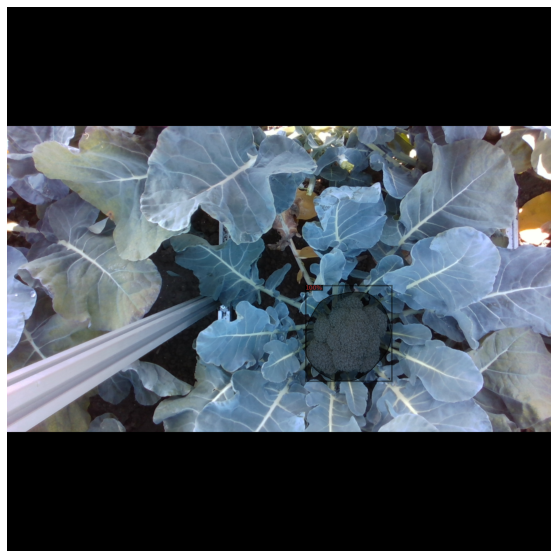

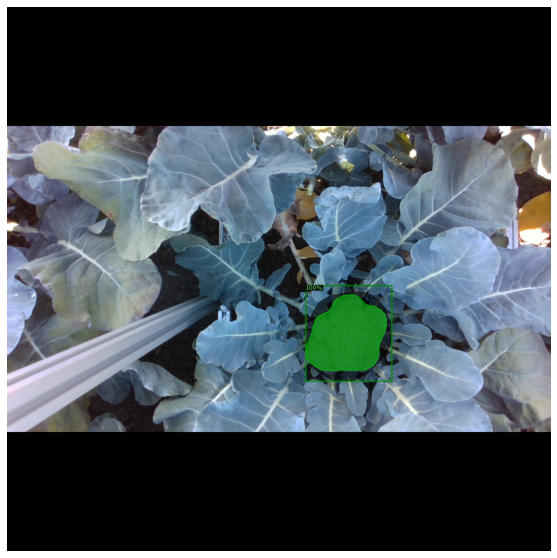

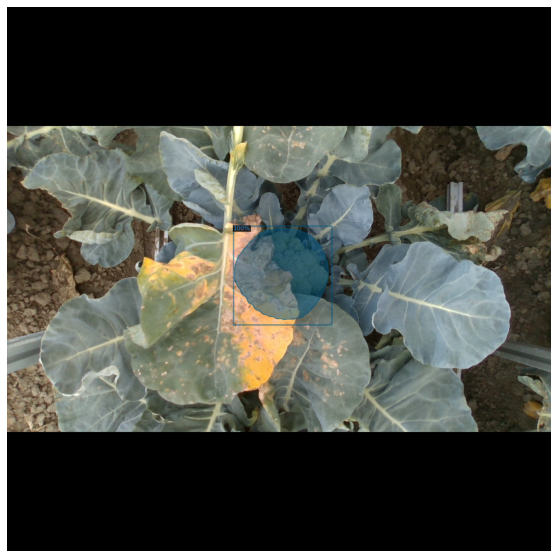

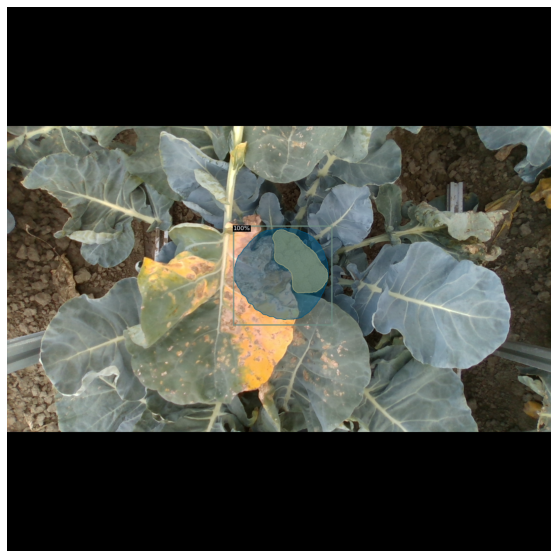

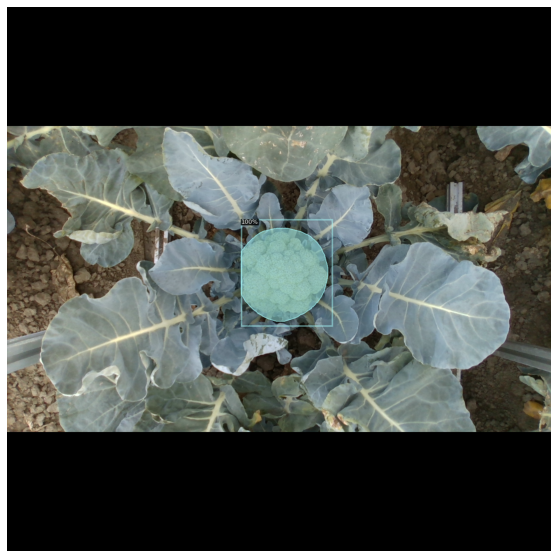

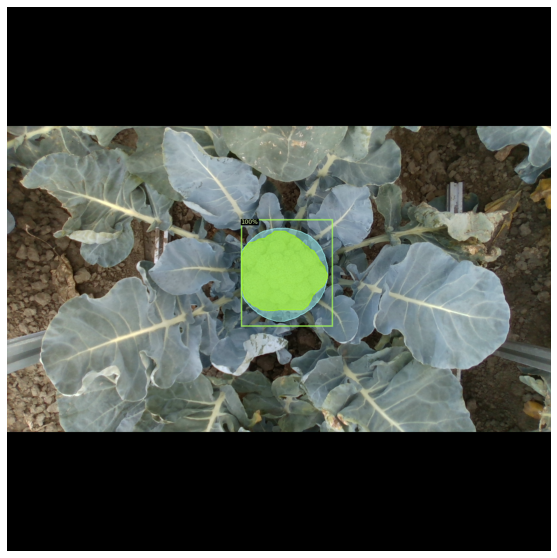

In [11]:
for d in random.sample(dataset_dicts_test, 3):       
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_test_metadata, scale=0.8)
    amodal_mask = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    imshow(amodal_mask.get_image()[:, :, ::-1])
    modal_mask = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"), 'pred_visible_masks')
    imshow(modal_mask.get_image()[:, :, ::-1])

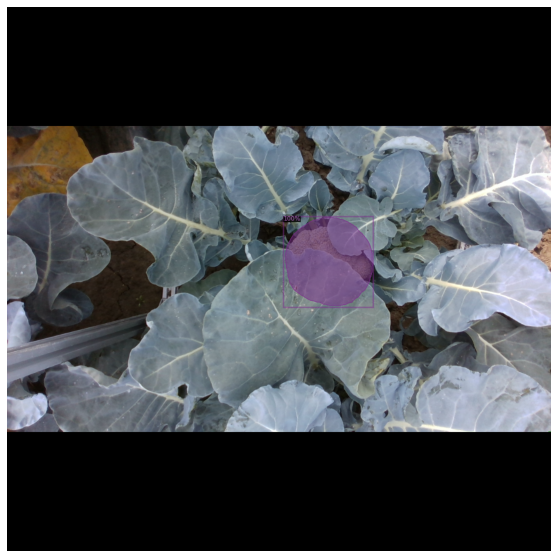

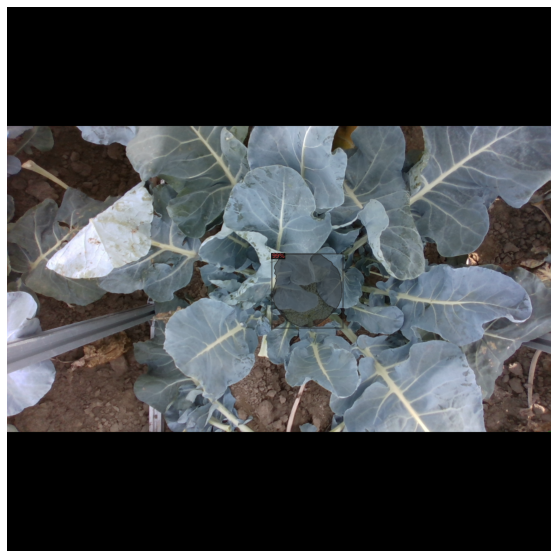

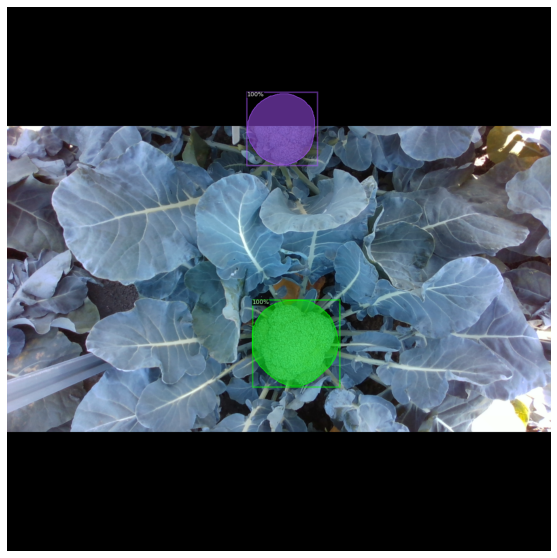

In [12]:
for d in random.sample(dataset_dicts_test, 3):       
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_test_metadata, scale=0.8)
    vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    imshow(vis.get_image()[:, :, ::-1])

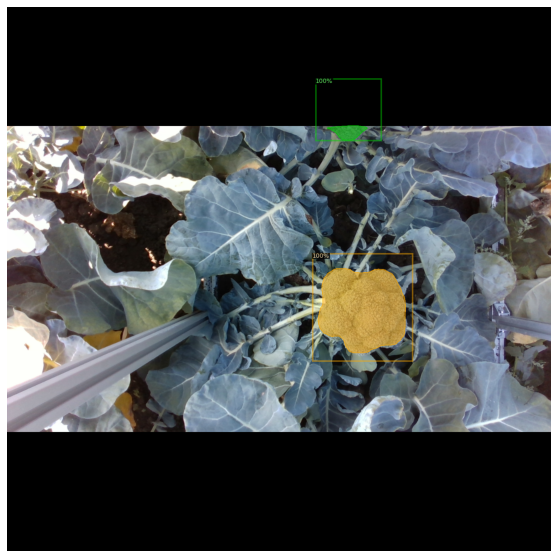

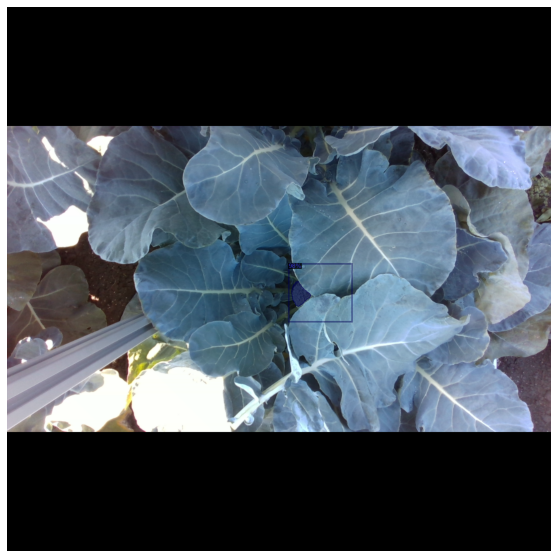

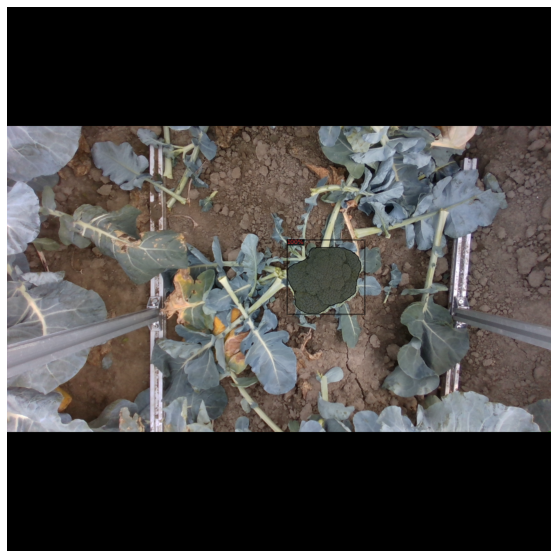

In [13]:
for d in random.sample(dataset_dicts_test, 3):       
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_test_metadata, scale=0.8)
    vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"), 'pred_visible_masks')
    imshow(vis.get_image()[:, :, ::-1])

In [14]:
#  evaluate its performance using AP metric implemented in COCO API.
from detectron2.evaluation import AmodalEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = AmodalEvaluator("broccoli_amodal_test", cfg, False, output_dir="/home/pieterdeeplearn/ORCNN/Results/broccoli_amodal_visible")
val_loader = build_detection_test_loader(cfg, "broccoli_amodal_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[09/10 17:48:56 d2.data.datasets.coco]: Loaded 362 images in COCO format from datasets/20201231_size_experiment_realsense/test/annotations.json
[09/10 17:48:56 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  broccoli  | 457          |
|            |              |
[09/10 17:48:56 d2.evaluation.evaluator]: Start inference on 362 images
[09/10 17:49:07 d2.evaluation.evaluator]: Inference done 11/362. 0.2026 s / img. ETA=0:05:49
[09/10 17:49:13 d2.evaluation.evaluator]: Inference done 17/362. 0.2022 s / img. ETA=0:05:38
[09/10 17:49:19 d2.evaluation.evaluator]: Inference done 23/362. 0.2014 s / img. ETA=0:05:30


KeyboardInterrupt: 

In [16]:
# for d in range(len(dataset_dicts_test)):
#     print(dataset_dicts_test[d]["file_name"])
#     img = cv2.imread(dataset_dicts_test[d]["file_name"])
#     outputs = predictor(img)
#     visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_test_metadata, scale=0.8)
#     vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
#     imshow(vis.get_image()[:, :, ::-1])

In [17]:
# for d in range(len(dataset_dicts_test)):
#     print(dataset_dicts_test[d]["file_name"])
#     img = cv2.imread(dataset_dicts_test[d]["file_name"])
#     outputs = predictor(img)
#     visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_test_metadata, scale=0.8)
#     vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"), 'pred_visible_masks')
#     imshow(vis.get_image()[:, :, ::-1])

In [18]:
## loss weight contribution:
## https://github.com/facebookresearch/detectron2/issues/1709